<a href="https://colab.research.google.com/github/raminnourizade/Proposal/blob/main/eeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

In [2]:
import gdown
import os
import numpy as np
import pandas as pd
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import glob
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import keras
from tensorflow.keras import layers
import sys
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, optimizers
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from scipy import signal



In [3]:
def load_data():
  path="dataset"
  if not os.path.exists(path):
      os.mkdir(path)
      print(f"Folder {path} created!")

      file_id = "1hG5v_COjPNzejRaL9XJAFERee9i2_V04"  # Replace this with your file's ID
      output_file = path+"/eeg.zip"  # Replace "data_file.ext" with the desired output filename and extension
      gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file)
      !unzip "dataset/eeg.zip" -d "dataset"
      os.remove("dataset/eeg.zip")

  else:
      print(f"Folder {path} already exists")


  ds_dir = '/content/dataset/'
  scaler = StandardScaler()
  all_eeg=[]

  for (i, item) in enumerate(glob.glob(ds_dir + '*.edf')):
    print(item)
    raw = mne.io.read_raw_edf(item)
    # Filter EEG channels ('P3' and 'C3')
    eeg_channels = [ch for ch in raw.info['ch_names'] if ch in channels]
    if len(eeg_channels) != len(channels):
        print(f"Error: channels not found in {item}. Skipping...")
        continue

    # Create a new Raw object with only EEG channels
    raw = raw.copy().pick_channels(eeg_channels)

    # Apply bandpass filter (example: 0.1 Hz - 40 Hz)
    raw.load_data()  # Load the data into memory
    raw.filter(l_freq=0.1, h_freq=40)

    # Segment data into epochs (e.g., 1-second epochs)
    events = mne.make_fixed_length_events(raw, duration=1.0)
    epochs = mne.Epochs(raw, events, tmin=0, tmax=1.0, baseline=None)

    X = epochs.get_data()
    # Standardize features (Z-score normalization)
    n_samples, n_channels, n_time_points = X.shape

    # Reshape to 2D (n_samples x (n_channels * n_time_points))
    #X_reshaped = X.reshape(n_samples, -1)
    X_reshaped=X
    # Apply StandardScaler

    # Compute mean and standard deviation along the time axis (axis 2)
    mean = np.mean(X_reshaped, axis=(0, 1, 2))
    std = np.std(X_reshaped, axis=(0, 1, 2))

    # Perform scaling
    eeg_data_scaled = (X_reshaped - mean) / std
    X_scaled = eeg_data_scaled

    all_eeg.append(X_scaled)


  #all_eeg=np.array(all_eeg)

  lb=LabelBinarizer()
  all_labels = pd.read_excel("/content/dataset/states.xlsx",usecols=["status"])
  all_labels=lb.fit_transform(all_labels)

  X_train, X_test, y_train, y_test = train_test_split(all_eeg, all_labels, test_size=0.2, random_state=42)

  # Convert X_train and X_test to numpy arrays




  return  X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points

In [4]:
channels= ['T3', 'T5', 'T4', 'T6','Fp2','F3','Fz','Pz','C3','P3','O1','O2']
X_train, X_test, y_train, y_test, n_samples, n_channels ,n_time_points = load_data()


Folder dataset already exists
/content/dataset/21.edf
Extracting EDF parameters from /content/dataset/21.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading 0 ... 462335  =      0.000 ...  1805.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8449 samples (33.004 s)

Not setting metadata
1806 matching events found
No baseline correction applied
0 projection items activ

In [5]:
print( "n_samples= {} and  n_channels = {} and n_time_points= {}".format(n_samples, n_channels ,n_time_points))

n_samples= 1911 and  n_channels = 12 and n_time_points= 257


In [6]:
# col_len=257*len(channels)

# for x in range(len(X_train)):
#  print(X_train[x].shape)
#  for x in range(len(X_train)):
#   X_train[x]=X_train[x][0:1802,0:12,0:col_len]
# for x in range(len(X_train)):
#   X_train[x]=X_train[x][0:1802,0:12,0:col_len]

# for x in range(len(X_test)):
#   X_test[x]=X_test[x][0:1802,0:12,0:col_len]


In [7]:
for x in range(len(X_train)):
  X_train[x]=X_train[x][0:1802,0:12,0:257]
for x in range(len(X_test)):
  X_test[x]=X_test[x][0:1802,0:12,0:257]

In [8]:
X_train=np.stack( X_train, axis=0 )
X_train = np.array(X_train)
#X_train_reshaped = X_train.reshape(len(X_train), n_channels, n_time_points, 1)

X_test=np.stack( X_test, axis=0 )
X_test = np.array(X_test)# Reshape the arrays
#X_test_reshaped = X_test.reshape(len(X_test), n_channels, n_time_points, 1)




In [9]:
np.shape(X_train)

(21, 1802, 12, 257)

In [10]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Patch creation
    patch_size = 4
    patches = layers.Conv2D(filters=64, kernel_size=patch_size, strides=patch_size, activation='relu')(inputs)

    # Flatten patches
    flattened_patches = layers.Flatten()(patches)

    # MLP head
    mlp_output = layers.Dense(256, activation='gelu')(flattened_patches)
    mlp_output = layers.Dropout(0.2)(mlp_output)

    # Classification head
    outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(mlp_output)

    model = models.Model(inputs=inputs, outputs=outputs)

    return model

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]  # Assuming RGB images (3 channels)

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        patches = tf.image.extract_patches(images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1], rates=[1, 1, 1, 1], padding="VALID")
        patches = tf.reshape(patches, (batch_size, num_patches_h * num_patches_w, self.patch_size * self.patch_size * channels))

        return patches


In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [13]:
mlp_head_units =[64, 32] ## [128, 64] #   [256, 128]
input_shape =np.shape(X_train[0])#  (1802, 12, 257)

In [14]:
print("Shapes of training data and labels:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("Shapes of testing data and labels:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Shapes of training data and labels:
X_train shape: (21, 1802, 12, 257)
y_train shape: (21, 1)
Shapes of testing data and labels:
X_test shape: (6, 1802, 12, 257)
y_test shape: (6, 1)


In [15]:
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [16]:
lr_callback = LearningRateScheduler(lr_scheduler)


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [28]:
def apply_augmentation(data, noise_level=0.1):
  np.random.seed(42)
  noise = np.random.normal(scale=noise_level, size=np.shape(data))
  augmented_data=data + noise

  return np.array(augmented_data)

In [29]:
X_train_augmented = apply_augmentation(X_train)
X_test_augmented = apply_augmentation(X_test)

In [20]:
vit_model = create_vit_model(input_shape, 2)
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1802, 12, 257)]   0         
                                                                 
 conv2d (Conv2D)             (None, 450, 3, 64)        263232    
                                                                 
 flatten (Flatten)           (None, 86400)             0         
                                                                 
 dense (Dense)               (None, 256)               22118656  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 22382402 (85.38 MB)
Trainable params: 22382402 

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)#
vit_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])  # Compile the model with the custom optimizer

In [22]:
y_test

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1]])

In [23]:
history = vit_model.fit(X_train_augmented, y_train, batch_size=16, epochs=20,
                        validation_data=(X_test_augmented, y_test), callbacks=[lr_callback])

Epoch 1/20
2/2 [==============================] - 6s 2s/step - loss: 14.7720 - accuracy: 0.3333 - val_loss: 3.3429 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
2/2 [==============================] - 3s 2s/step - loss: 0.7460 - accuracy: 0.9048 - val_loss: 27.7903 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
2/2 [==============================] - 4s 2s/step - loss: 20.0217 - accuracy: 0.3810 - val_loss: 16.3460 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/20
2/2 [==============================] - 2s 1s/step - loss: 1.1190 - accuracy: 0.9048 - val_loss: 17.9025 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
2/2 [==============================] - 3s 2s/step - loss: 2.2012 - accuracy: 0.9048 - val_loss: 24.6769 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
2/2 [==============================] - 2s 1s/step - loss: 1.0273 - accuracy: 0.9524 - val_loss: 15.2993 - val_accuracy: 0.3333 - lr: 9.0484e-04
Epoch 7/20
2/2 [==============================] - 4s 3s/step - loss: 0.0000e+00 - accurac

In [24]:
test_loss, test_accuracy = vit_model.evaluate(X_test_augmented, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 [==============================] - 0s 245ms/step - loss: 83.3928 - accuracy: 0.6667
Test Loss: 83.3928, Test Accuracy: 0.6667


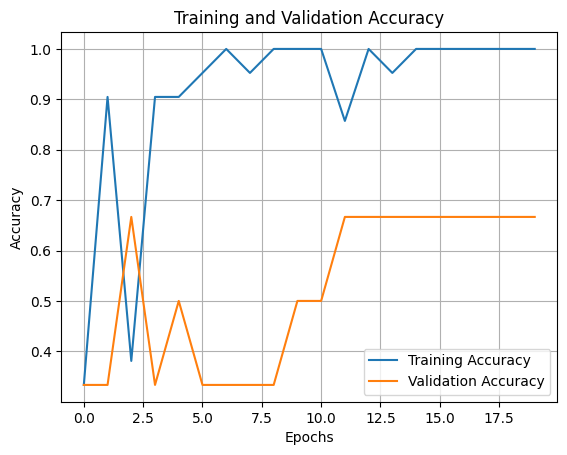

In [25]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

